# Mesh

## Imports

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Data

In [2]:
mesh = xr.open_dataset('../data/model/orca05l75_domain_cfg_nemov5_10m.nc')
model = xr.open_dataset('../data/model/nemo00_1m_201001_202212_Eq.nc')

<xarray.Dataset>
Dimensions:       (y: 510, x: 720, nav_lev: 75, nlines: 54)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x, nlines
Data variables: (12/33)
    e1v           (y, x) float64 ...
    e2u           (y, x) float64 ...
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    glamt         (y, x) float64 ...
    glamu         (y, x) float64 ...
    ...            ...
    e3uw_0        (nav_lev, y, x) float64 ...
    e3vw_0        (nav_lev, y, x) float64 ...
    bottom_level  (y, x) int32 ...
    top_level     (y, x) int32 ...
    bathy_metry   (y, x) float64 ...
    namelist_cfg  (nlines) |S102 ...
Attributes:
    history:      Tue Sep 10 21:54:46 2024: ncap2 -O --ftn -s           /* Gi...
    CfgName:      ORCA
    CfgIndex:     5
    Iperio:       1
    Jperio:       0
    NFold:        1
    NFtype:       F
    VertCoord:    zps
    IsfCav:       0
    NEMOversion:  5.0
    NCO:          netCDF Operators version 5.2.8 (Homepage = http://nco.sf.ne...

## Analysis

In [3]:
x=100
y=0

In [4]:
mesh.nav_lon.sel(x=x,y=y).values

array(123.25, dtype=float32)

In [5]:
mesh.nav_lat.sel(x=x,y=y).values

array(-77.010475, dtype=float32)

In [6]:
mesh.glamt.sel(x=x,y=y).values

array(123.25)

In [7]:
mesh.gphit.sel(x=x,y=y).values

array(-77.01047555)

In [8]:
mesh.nav_lon.sel(y=255).values

array([  73.25,   73.75,   74.25,   74.75,   75.25,   75.75,   76.25,
         76.75,   77.25,   77.75,   78.25,   78.75,   79.25,   79.75,
         80.25,   80.75,   81.25,   81.75,   82.25,   82.75,   83.25,
         83.75,   84.25,   84.75,   85.25,   85.75,   86.25,   86.75,
         87.25,   87.75,   88.25,   88.75,   89.25,   89.75,   90.25,
         90.75,   91.25,   91.75,   92.25,   92.75,   93.25,   93.75,
         94.25,   94.75,   95.25,   95.75,   96.25,   96.75,   97.25,
         97.75,   98.25,   98.75,   99.25,   99.75,  100.25,  100.75,
        101.25,  101.75,  102.25,  102.75,  103.25,  103.75,  104.25,
        104.75,  105.25,  105.75,  106.25,  106.75,  107.25,  107.75,
        108.25,  108.75,  109.25,  109.75,  110.25,  110.75,  111.25,
        111.75,  112.25,  112.75,  113.25,  113.75,  114.25,  114.75,
        115.25,  115.75,  116.25,  116.75,  117.25,  117.75,  118.25,
        118.75,  119.25,  119.75,  120.25,  120.75,  121.25,  121.75,
        122.25,  122

In [9]:
for y in [0, 100, 200, 300]:
    for x in [0, 100, 200, 200]:
        print("y =", y, "x =", x)
        levels = mesh.bottom_level.sel(y=y, x=x).values
        depth = 0.0
        levels = mesh.bottom_level.sel(y=y, x=x).values
        if levels > 0:
            for i in range(levels - 1):
                depth += mesh.e3t_1d.isel(nav_lev=i).values
            depth += mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=levels - 1).values
        print("calculated depth =", depth)
        print("bathymetry =", mesh.bathy_metry.sel(y=y, x=x).values)
        print("################")

y = 0 x = 0
calculated depth = 0.0
bathymetry = 0.0
################
y = 0 x = 100
calculated depth = 0.0
bathymetry = 0.0
################
y = 0 x = 200
calculated depth = 0.0
bathymetry = 0.0
################
y = 0 x = 200
calculated depth = 0.0
bathymetry = 0.0
################
y = 100 x = 0
calculated depth = 2778.0
bathymetry = 2778.0
################
y = 100 x = 100
calculated depth = 4552.0
bathymetry = 4552.0
################
y = 100 x = 200
calculated depth = 4988.667323918189
bathymetry = 4988.667323918189
################
y = 100 x = 200
calculated depth = 4988.667323918189
bathymetry = 4988.667323918189
################
y = 200 x = 0
calculated depth = 3755.0
bathymetry = 3755.0
################
y = 200 x = 100
calculated depth = 0.0
bathymetry = 0.0
################
y = 200 x = 200
calculated depth = 4104.5
bathymetry = 4104.5
################
y = 200 x = 200
calculated depth = 4104.5
bathymetry = 4104.5
################
y = 300 x = 0
calculated depth = 0.0
bathymetry = 0.

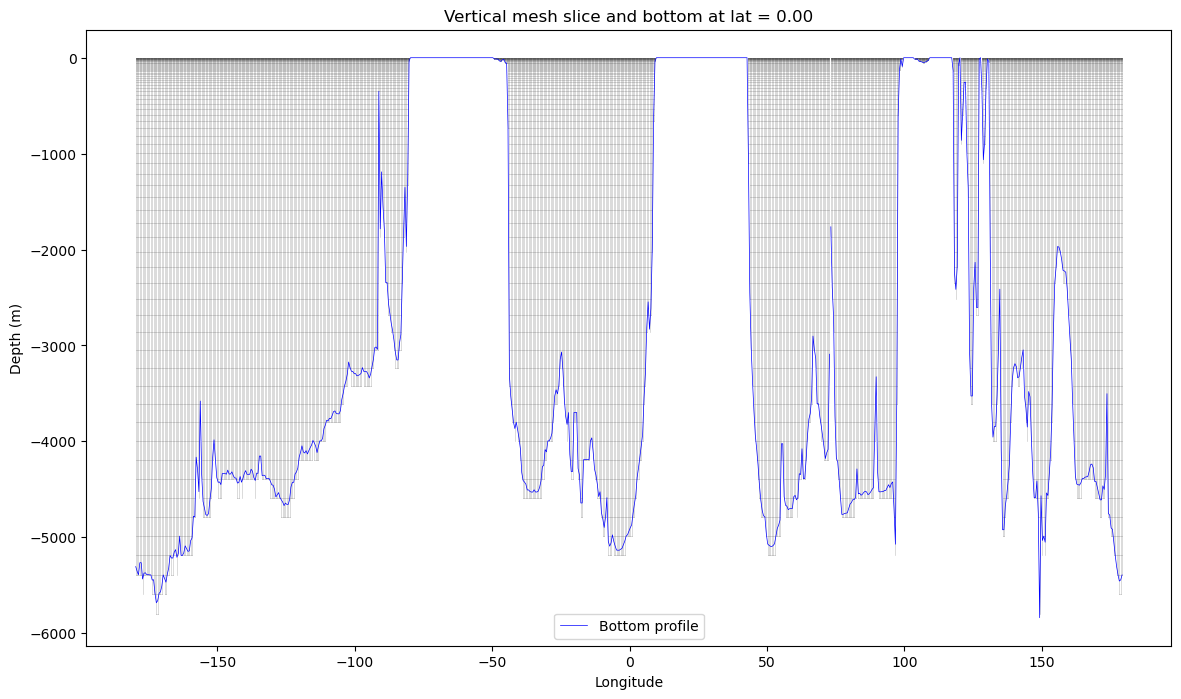

In [36]:
y = 249
nx = mesh.sizes["x"]
nlev = mesh.sizes["nav_lev"]
nav_lon = mesh.nav_lon.sel(y=y).values
bottom_levels = mesh.bottom_level.sel(y=y).values  # shape (nx,)
depth_grid = mesh.e3t_1d.values  
depths = np.zeros(nx)

for x in range(nx):
    level = bottom_levels[x]
    if level > 0:
        depths[x] = mesh.e3t_1d.isel(nav_lev=slice(0, level-1)).sum().values
        depths[x] += mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level-1).values

# Get rid of a connecting line along the whole plot
jump_value = 179.75
tol = 1e-5  
indices = np.where(np.abs(nav_lon - jump_value) < tol)[0]
nav_lon[indices] = np.nan
depths[indices] = np.nan

# Prepare 2D arrays for plotting
depth_cumsum = -np.cumsum(np.tile(depth_grid[:, np.newaxis], (1, nx)), axis=0)  # (nlev, nx)
valid_mask = np.zeros((nlev, nx))
for x in range(nx):
    valid_mask[:bottom_levels[x], x] = 1
depth_cumsum_masked = np.where(valid_mask, depth_cumsum, np.nan)

plt.figure(figsize=(14, 8))
# Plot the mesh grid as thin gray lines
for lev in range(nlev):
    plt.plot(nav_lon, depth_cumsum_masked[lev, :], color='k', alpha=0.2, linewidth=0.5)          # horiznotal lines
for x in range(nx):
    plt.plot([nav_lon[x]]*nlev, depth_cumsum_masked[:, x], color='k', alpha=0.2, linewidth=0.5)  # vertical lines
# Plot the bottom profile
plt.plot(nav_lon, -depths, color='blue', linewidth=0.5, label="Bottom profile")

# Labels
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")
plt.title(f"Vertical mesh slice and bottom at lat = {mesh.nav_lat.sel(y=y).values.mean():.2f}")
plt.legend()
plt.show()

In [ ]:
y = 249
nx = mesh.sizes["x"]
nlev = mesh.sizes["nav_lev"]
bottom_levels = mesh.bottom_level.sel(y=y).values  # shape (nx,)

valid_mask = np.zeros((nlev, nx), dtype=bool)
for x in range(nx):
    valid_mask[:bottom_levels[x], x] = True


# Create 2D longitude array by repeating the 1D longitude values across depth levels
lon2d = np.tile(model.nav_lon_grid_T.values, (nlev, 1))[valid_mask]

# Initialize a 2D depth array with nominal depth values (shape: [nlev, nx])
depth2d = np.repeat(model.deptht.values[:, np.newaxis], nx, axis=1)

# Adjust depth at the bottom level using vertical thickness (e3t_0) from the mesh
for x in range(nx):
    level = bottom_levels[x]
    if level > 0:  # skip land or invalid points
        if level > 1:
            # Add the vertical thickness to the depth just above
            thickness = mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level - 1).values
            depth2d[level - 1, x] = depth2d[level - 2, x] + thickness
        else:
            # At the surface, just use the thickness
            depth2d[level - 1, x] = mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level - 1).values

# Flip depth to positive-downward convention and mask invalid points
depth1d = -depth2d[valid_mask]

# Extract valid temperature values
T = (model["to"].isel(time_counter=0, y_grid_T=0).values)
T1d = T[valid_mask]

# Plot temperature vs. longitude and depth
plt.scatter(lon2d, depth1d, c=T1d, s=1)
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")
plt.colorbar(label="Temperature (°C)")
plt.show()